Neural Networks 104 - Training Loop

วิธีการเทรน นิวรอลเน็ตเวิร์ก ทีละขั้นตอน แบบเข้าใจง่าย

# 0. Magic

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# 1. Import

In [2]:
import torch
from torch import tensor
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch
import operator

# 2. Data

In [3]:
MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

In [4]:
def get_data():
    path = datasets.download_data(MNIST_URL, ext='.gz')
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(tensor, (x_train, y_train, x_valid, y_valid))

In [5]:
x_train, y_train, x_valid, y_valid = get_data()

# 3. เตรียม Data

In [6]:
# x = data, m = mean, s = standard deviation
def normalize(x, m, s): 
    return (x-m)/s

In [7]:
train_mean, train_std = x_train.mean(), x_train.std()
x_train = normalize(x_train, train_mean, train_std)
x_valid = normalize(x_valid, train_mean, train_std)

In [8]:
n, m = x_train.shape
c = y_train.max()+1
n, m, c

(50000, 784, tensor(10))

# 4. สร้าง Model

โมเดลจะประกอบด้วยส่วนต่าง ๆ เช่น Architecture กำหนด Layers ต่าง ๆ, Initialization, Loss Function, อัลกอริทึมในการเทรน และ Metrics ที่เราเรียนรู้กันไปใน ep ก่อน ๆ 

โมเดล

In [9]:
class Model(nn.Module):
    # number of input feature, number of hidden feature, number of output feature
    def __init__(self, n_in, nh, n_out):
        super().__init__()
#         set_trace()
        self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)]        
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x

เคสนี้เป็นงาน Classification เราจะใช้ [Cross Entropy Loss Fucntion](https://www.bualabs.com/wp-admin/post.php?post=1945&action=edit)

In [10]:
# loss function
loss_func = F.cross_entropy

ในเคสนี้เราจะใช้ [metrics เป็น Accuracy](https://www.bualabs.com/archives/1968/what-is-metrics-confusion-matrix-accuracy-precision-recall-f1-score-difference-metrics-ep-1/) ประกาศฟังก์ชัน accuracy 

In [11]:
def accuracy(yhat, y):
    return (torch.argmax(yhat, dim=-1) == y).float().mean()

กำหนด Hyperparameter

In [12]:
# batch size
bs = 64
# learning rate
lr = 0.03
epoch = 1
nh = 50

แบ่งข้อมูลออกมา 1 Batch

In [13]:
# x batch
xb = x_train[:bs]
yb = y_train[:bs]

สร้างโมเดล จาก Hyperparameter ด้านบน

In [14]:
model = Model(m, nh, c.numpy())

ลองให้โมเดล จำแนก MNIST โดยที่ยังไม่ได้เทรน

In [15]:
# predictions
preds = model(xb)
preds[0]

tensor([ 0.1040, -0.1245, -0.0690,  0.0228, -0.0210, -0.0707, -0.3045, -0.1462,
        -0.0215, -0.3839], grad_fn=<SelectBackward>)

ได้ Output ออกมา 10 Class

In [16]:
preds[0].shape

torch.Size([10])

ลองเทส Loss Fuction

In [17]:
loss = loss_func(preds, yb)
loss

tensor(2.2979, grad_fn=<NllLossBackward>)

เทส Accuracy ได้ประมาณ 10% เหมือน Random เพราะเรายังไม่ได้เทรน

In [18]:
accuracy(preds, yb)

tensor(0.1250)

# 5. Training Loop

เราจะเทรนโมเดล ด้วยอัลกอริทึม [Stochastic Gradient Descent (SGD)](https://www.bualabs.com/wp-admin/post.php?post=631&action=edit) และ เก็บ Loss, Accuracy เอาไว้พล็อตกราฟ

In [19]:
losses, metrics = [], []

ประกาศฟังก์ชัน แบ่งข้อมูลเป็น Mini-batch 

In [20]:
def get_databatch(b):
    start_b = b*bs
    end_b = start_b+bs
    return x_train[start_b:end_b], y_train[start_b:end_b]

วนลูปเทรน ตามจำนวน epoch

In [21]:
# e = epoch number
for e in range(epoch):
    # b = batch number
    for b in range((n-1)//bs + 1):
        
        # Feedforward
        xb, yb = get_databatch(b)
        yhatb = model(xb)
        loss = loss_func(yhatb, yb)

        # Metrics
        acc = accuracy(yhatb, yb)
        losses.append(loss); metrics.append(acc)
        
        # Backpropagation
        loss.backward()
        
        # Update Wight and Bias with SGD
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias   -= l.bias.grad * lr 
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()       
                    

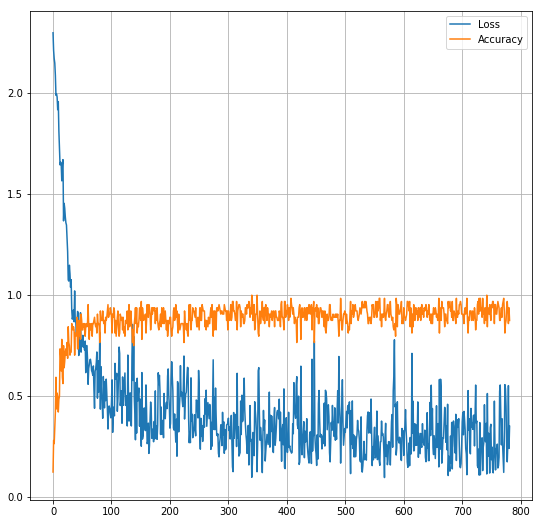

In [22]:
x = torch.arange(n//bs+1).numpy()
fig,ax = plt.subplots(figsize=(9, 9))
ax.grid(True)
ax.plot(x, losses, label="Loss")
ax.plot(x, metrics, label="Accuracy")
ax.legend(loc='upper right')

ลองเทสดู Loss และ Accuracy อีกครั้ง

In [23]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1627, grad_fn=<NllLossBackward>), tensor(0.9375))

# 6. Validation Set

แต่การเทสกับข้อมูลที่ใช้เทรนโมเดล ไม่ใช่สิ่งที่ควรทำ เราควรเทสกับ Validation Set จากที่อธิบายไว้ใน ep [Train / Test Split คืออะไร ทำไมเราต้องแยกชุดข้อมูล เป็น Training, Validation และ Test Set ใน Machine Learning](https://www.bualabs.com/archives/532/what-is-train-test-split-why-split-train-set-validation-set-test-set/)

In [24]:
xb = x_valid[:bs*2]
yb = y_valid[:bs*2]

ได้ Accuracy พอ ๆ กัน

In [25]:
yhat = model(xb)
loss_func(yhat, yb), accuracy(yhat, yb)

(tensor(0.2768, grad_fn=<NllLossBackward>), tensor(0.9219))

ลองดูรูปภาพ เปรียบเทียบกับ ผลการทำนายจากโมเดล

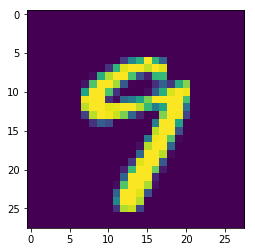

In [26]:
plt.imshow(xb[99].view(28,28))

In [27]:
yhat[99].argmax()

tensor(9)

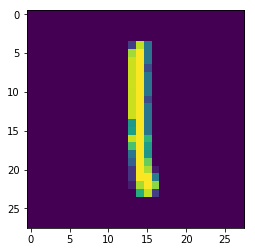

In [28]:
plt.imshow(xb[55].view(28,28))

In [29]:
yhat[55].argmax()

tensor(1)

# 7. สรุป

1. เราได้สร้าง Neural Network ตั้งแต่ต้น ด้วยการประกอบชิ้นส่วนทุกอย่างเข้าด้วยกัน สร้าง Training Loop เพื่อเริ่มต้นเทรน Feed Forward, หาค่า Loss, เพื่อ Backpropagation, หา Gradient, ไปจนถึงอัพเดท Weight และ Bias, ก่อนเริ่มต้นเทรน Batch / Epoch ถัดไป
1. เราได้คำนวน Metrics ว่าโมเดลของเราทำงานถูกต้อง แม่นยำ แค่ไหน มี Accuracy เท่าไร
1. ในเคสนี้โมเดลเป็นแบบ Classification แต่ถ้าเป็นงาน Regression เราก็ปรับโมเดล เปลี่ยนแค่ Layer สุดท้าย, Loss Function และ Metrics เท่านั้น ชิ้นส่วนอื่น ๆ เราสามารถ Reuse ได้เกือบหมด
1. ถ้ามีความรู้ความเข้าใจในทุกส่วนประกอบของ Neural Network เราจะสามารถออกแบบ สร้างโมเดลที่แก้ปัญหาซับซ้อนยิ่งขึ้นได้
1. ในเคสนี้ Training Loop เป็นแบบง่ายที่สุด ยังสามารถ Optimize ได้อีกหลายจุด ทั้ง Training Loop และ สถาปัตยกรรมของโมเดล จะอธิบายต่อไป

# Credit 

* https://course.fast.ai/videos/?lesson=9
* http://cs231n.github.io/neural-networks-1/